In [1]:
# !aws s3 cp s3://largedonor/Crohns.zip .
# !unzip Crohns.zip

In [2]:
import sys
sys.path.insert(0, '/data/yosef3/users/can/mrvi_ibd/scvi-v2/src')
import scvi_v2
scvi_v2.__file__

Global seed set to 0
/data/yosef3/users/can/conda/envs/mrvi_v3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/data/yosef3/users/can/mrvi_ibd/scvi-v2/src/scvi_v2/__init__.py'

In [3]:
import pandas as pd
import glob
import os
import scanpy as sc
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import pymde
from scipy.cluster.hierarchy import linkage, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import pymde

In [4]:
cd /data/yosef3/users/can/immune_aging/mrvi_analysis

/data/yosef3/users/can/immune_aging/mrvi_analysis


In [5]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Run mrVI

In [6]:
immune_aging = sc.read('/data/yosef3/users/can/immune_aging/doublet_removal/processing_results_newest/process_integration/All_filtered/All_filtered.unstim_cleanup.v2.h5ad')

Only considering the two last: ['.v2', '.h5ad'].
Only considering the two last: ['.v2', '.h5ad'].


In [7]:
celltypes_steven = pd.read_parquet('analysis_classification_25_knn.pqt', engine='pyarrow')
immune_aging = immune_aging[celltypes_steven.index]
immune_aging.obs['celltypes_steven'] = celltypes_steven.loc[immune_aging.obs_names]

celltypes_steven_old = pd.read_parquet('analysis_classification_knn.pqt', engine='pyarrow')
immune_aging = immune_aging[celltypes_steven_old.index]
immune_aging.obs['celltypes_steven_old'] = celltypes_steven_old.loc[immune_aging.obs_names]

dan_correction = pd.read_csv('NY_DR_disagreement_annotation.csv', index_col=0)
immune_aging.obs['dan_correction'] = immune_aging.obs['celltypes_steven'].astype(str)
immune_aging.obs.loc[dan_correction.index, 'dan_correction'] = dan_correction['DR_NY_annotation']

celltypes_groups = pd.read_parquet('schpf_groups.pqt', engine='pyarrow')
celltypes_groups.head()
immune_aging.obs['schpf_groups'] = celltypes_groups

dan_fine_annotation = pd.read_csv('NY_DR_annotation_26thMay2023.csv', index_col=0)
immune_aging.obs['dan_fine_annotion'] = dan_fine_annotation

/tmp/ipykernel_3875763/3900671283.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  immune_aging.obs['celltypes_steven'] = celltypes_steven.loc[immune_aging.obs_names]
/tmp/ipykernel_3875763/3900671283.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  immune_aging.obs['celltypes_steven_old'] = celltypes_steven_old.loc[immune_aging.obs_names]


In [8]:
2

2

In [9]:
immune_aging = immune_aging[~immune_aging.obs['dan_correction'].str.contains('lqe')]
immune_aging = immune_aging[immune_aging.obs['celltypes_steven'].dropna().index]
immune_aging = immune_aging[~immune_aging.obs['dan_correction'].isin(['epithelial', 'endothelial', 'fibroblast'])]
immune_aging = immune_aging[~immune_aging.obs['tissue'].isin(['THY'])]

immune_aging.obs['donor_tissue'] = immune_aging.obs['donor'].astype(str) + '_' + immune_aging.obs['tissue'].astype(str)
immune_aging.obs['site_tech'] = immune_aging.obs['site'].astype(str) + '_' + immune_aging.obs['chemistry'].astype(str)
immune_aging.obs['donor_site_tech'] = immune_aging.obs['donor'].astype(str) + '_' + immune_aging.obs['site'].astype(str) + '_' + immune_aging.obs['chemistry'].astype(str)

/tmp/ipykernel_3875763/2524761403.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  immune_aging.obs['donor_tissue'] = immune_aging.obs['donor'].astype(str) + '_' + immune_aging.obs['tissue'].astype(str)


In [10]:
immune_aging.layers['counts'] = immune_aging.X.copy()
sc.pp.normalize_total(immune_aging)
sc.pp.log1p(immune_aging)

In [11]:
sc.pp.highly_variable_genes(
    immune_aging, n_top_genes=6000, subset=True, flavor='seurat_v3',
    batch_key='site_tech', layer='counts')

In [12]:
import flax.linen as nn
import jax.numpy as jnp

train_kwargs = {
    "early_stopping": True,
    "plan_kwargs": {"lr": 1e-3, "n_epochs_kl_warmup": 25},
}

model_kwargs = {
    "qz_nn_flavor": "attention",
    "px_nn_flavor": "attention",
    "qz_kwargs": {
        "use_map": False,
        "stop_gradients": False,
        "stop_gradients_mlp": True,
        "dropout_rate": 0.03,
    },
    "px_kwargs": {
        "stop_gradients": False,
        "stop_gradients_mlp": True,
        "h_activation": nn.softmax,
        "dropout_rate": 0.03,
        "low_dim_batch": True,
    },
    "learn_z_u_prior_scale": False,
    "z_u_prior": False,
    "u_prior_mixture": False,
    "n_latent": 76,
    "u_prior_mixture": True,
    "u_prior_mixture_k": 30,
}

In [13]:
from scvi_v2 import MrVI

In [ ]:
retrain = True

if retrain==True:
    scvi_v2.MrVI.setup_anndata(immune_aging, sample_key="donor", batch_key="site_tech", layer="counts", labels_key='dan_fine_annotion')
    mrvi_model = scvi_v2.MrVI(immune_aging, **model_kwargs)
    mrvi_model.train(max_epochs=50, **train_kwargs)
    mrvi_model.save("immuneaging_mrvi_donor", save_anndata=True, overwrite=True)
else:
    mrvi_model = scvi_v2.MrVI.load("immuneaging_mrvi_donor")
immune_aging = mrvi_model.adata
# Get z representation
immune_aging.obsm["X_mrvi_z"] = mrvi_model.get_latent_representation(give_z=True)
# Get u representation
immune_aging.obsm["X_mrvi_u"] = mrvi_model.get_latent_representation(give_z=False)

In [ ]:
immune_aging.obs['dan_fine_annotion']

In [ ]:
mrvi_model.module.n_labels

In [ ]:
donor_info = mrvi_model.donor_info
donor_info.index = donor_info['donor']

In [ ]:
mrvi_model.history_["elbo_train"][5:].plot()
mrvi_model.history_["elbo_validation"][5:].plot()

In [ ]:
immune_aging = immune_aging[immune_aging.obs['dan_fine_annotion']!='remove_from_disagreement']

In [ ]:
immune_aging

In [ ]:
sc.pp.neighbors(immune_aging, use_rep="X_mrvi_u", key_added="mrvi_u", n_neighbors=15)
sc.tl.paga(immune_aging, groups='celltypes_steven', neighbors_key='mrvi_u')
sc.pl.paga(immune_aging)

In [ ]:
2

In [ ]:
sc.pp.neighbors(immune_aging, use_rep="X_mrvi_z", key_added="mrvi_z", n_neighbors=15)
sc.tl.umap(immune_aging, neighbors_key="mrvi_z", min_dist=0.5, init_pos='paga')
sc.pl.umap(immune_aging, color=['donor', 'tissue', 'site', 'celltypes_steven'], neighbors_key="mrvi_z")

In [ ]:
sc.pp.neighbors(immune_aging, use_rep="X_mrvi_u", key_added="mrvi_u", n_neighbors=15)
sc.tl.umap(immune_aging, neighbors_key="mrvi_u", min_dist=0.4, init_pos='paga')
sc.pl.umap(immune_aging, color=['donor', 'tissue', 'site'], neighbors_key="mrvi_u")

In [ ]:
sc.pl.umap(immune_aging, color=['MKI67'])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

sc.pl.umap(
    immune_aging, 
    color="dan_fine_annotion",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="large",
    ax=ax, neighbors_key="mrvi_u", size=10
)

In [ ]:
sc.pl.umap(immune_aging, color=['donor', 'tissue', 'site_tech'], neighbors_key="mrvi_u")

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    immune_aging, 
    color="celltypes_steven",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, neighbors_key="mrvi_u", size=10
)

In [ ]:
sc.pl.umap(immune_aging, color=['donor', 'tissue', 'site_tech'], neighbors_key="mrvi_u")

In [ ]:
sc.pl.umap(immune_aging, color=['donor', 'tissue', 'site_tech'], neighbors_key="mrvi_u")

In [ ]:
sc.pl.umap(
    immune_aging, 
    color=["CD8A", "XCR1", "ITGAM", "ITGAX", "CCL19", "CCR7", "CD68"], size=1
)

In [ ]:
celltypes_groups = pd.read_parquet('schpf_groups.pqt', engine='pyarrow')
celltypes_groups.head()
immune_aging.obs['schpf_groups'] = celltypes_groups

In [ ]:
immune_aging.obs['age_int'] = [int(i.split('-')[0]) for i in immune_aging.obs['age']]
immune_aging.obs['age_group3'] = ['<30' if i<30 else '>60' if i>60 else '30-60' for i in immune_aging.obs['age_int']]
immune_aging.obs['age_group2'] = ['<40' if i<40 else '>40' for i in immune_aging.obs['age_int']]

In [ ]:
immune_aging.obs[['cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period']] = immune_aging.obsm['donor_level_obs'][['cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period']]
sc.pl.umap(immune_aging, color=['ebv', 'cmv', 'age_group2', 'age_group3', 'bmi', 'height', 'smoking_period', 'DCD/DBD'])

In [ ]:
cell_sample_sample_distances = mrvi_model.get_local_sample_distances(batch_size=2048, use_vmap=True, normalize_distances=True, norm='l2', mc_samples=20)

In [ ]:
donor_info = immune_aging.obs.drop_duplicates("donor").set_index("donor")
bad_samples = []
#filtering_mask = donor_info[~donor_info.index.isin('NY')].index
healthy_mask = donor_info[donor_info["site"] == "NY"].index
#ibd_mask = donor_info[donor_info["Type"] != "Healthy"].index
#tissue_mask = donor_info[donor_info["tissue"] == "ileum"].index
#chemistry_mask = donor_info[donor_info["Chem"] != "v1"].index
#lp_mask = donor_info[donor_info["Layer"] == "L"].index

site_color_mapping = {
    "NY": "red",
    "UK": "green"
}
chemistry_color_mapping = {
    "5'v2": "#CACF85",
    "3'v3": "#8CBA80"
}
sex_color_mapping = {
    "Male": "#1F77B4",
    "Female": "#FF7F0E",
}
age_color_mapping = {
    '<30': 'blue',
    '30-60': "orange",
    '>60': "red"
}
age2_color_mapping = {
    '<40': 'blue',
    '>40': "red"
}

In [ ]:
dmats = cell_sample_sample_distances

In [ ]:
dmat1 =(
    dmats['cell']
    .mean('cell_name')
    .squeeze()
    .to_pandas()
)
dists = squareform(dmat1.values)
Z = linkage(dists, method="complete")
Z = optimal_leaf_ordering(Z, dists)

from matplotlib.patches import Patch

subset_donor_info = donor_info.loc[dmat1.index]

color_site = subset_donor_info["site"].map(site_color_mapping)
color_chemistry = subset_donor_info["chemistry"].map(chemistry_color_mapping)
color_tissue = np.array(immune_aging.uns['tissue_colors'])[subset_donor_info["tissue"].cat.codes]
color_age = subset_donor_info["age_group3"].map(age_color_mapping)
color_age2 = subset_donor_info["age_group2"].map(age2_color_mapping)
color_sex = subset_donor_info["sex"].map(sex_color_mapping)
color_ebv = np.array(immune_aging.uns['ebv_colors'])[subset_donor_info["ebv"].cat.codes]
color_cmv = np.array(immune_aging.uns['cmv_colors'])[subset_donor_info["cmv"].cat.codes]
color_bmi = np.array(immune_aging.uns['bmi_colors'])[subset_donor_info["bmi"].cat.codes]
color_height = np.array(immune_aging.uns['height_colors'])[subset_donor_info["height"].cat.codes]
color_smoking_period = np.array(immune_aging.uns['smoking_period_colors'])[subset_donor_info["smoking_period"].cat.codes]
color_dcd_dbd = np.array(immune_aging.uns['DCD/DBD_colors'])[subset_donor_info["DCD/DBD"].cat.codes]

sns.clustermap(dmat1, row_linkage=Z, col_linkage=Z, cmap="viridis",
           row_colors=[color_chemistry, color_site, color_sex, color_age, color_age2, color_cmv],
           yticklabels=False, xticklabels=False)

handles = [Patch(facecolor=site_color_mapping[name]) for name in site_color_mapping]
site_legend = plt.legend(handles, site_color_mapping, title='Cell_Fraction',
           bbox_to_anchor = (1.2, 1.0),bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(site_legend)
handles = [Patch(facecolor=i) for i in immune_aging.uns['donor_colors']]
donor_legend = plt.legend(handles, immune_aging.obs['donor'].cat.categories, title='Donor',
           bbox_to_anchor = (1.2, 0.9),bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(donor_legend)
handles = [Patch(facecolor=i) for i in immune_aging.uns['tissue_colors']]
location_legend = plt.legend(handles, immune_aging.obs['tissue'].cat.categories, title='Tissue',
           bbox_to_anchor = (1.2, 0.35),bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.title('all')
plt.show()

In [ ]:
ct = 'macrophage'
tissue = 'LNG'
dmat1 =(
    dmats['cell']
    .loc[immune_aging.obs_names[np.logical_and(immune_aging.obs['celltypes_steven']==ct, immune_aging.obs['tissue']==tissue)]]
    .mean('cell_name')
    .squeeze()
    .to_pandas()
)
dists = squareform(dmat1.values)
Z = linkage(dists, method="complete")
Z = optimal_leaf_ordering(Z, dists)

from matplotlib.patches import Patch

subset_donor_info = donor_info.loc[dmat1.index]
subset_donor_info['donor'] = subset_donor_info.index

color_site = subset_donor_info["site"].map(site_color_mapping)
color_chemistry = subset_donor_info["chemistry"].map(chemistry_color_mapping)
color_tissue = np.array(immune_aging.uns['tissue_colors'])[subset_donor_info["tissue"].cat.codes]
color_age = subset_donor_info["age_group3"].map(age_color_mapping)
color_age2 = subset_donor_info["age_group2"].map(age2_color_mapping)
color_sex = subset_donor_info["sex"].map(sex_color_mapping)
color_ebv = np.array(immune_aging.uns['ebv_colors'])[subset_donor_info["ebv"].cat.codes]
color_donor = np.array(immune_aging.uns['donor_colors'])[subset_donor_info["donor"].cat.codes]
color_cmv = np.array(immune_aging.uns['cmv_colors'])[subset_donor_info["cmv"].cat.codes]
color_bmi = np.array(immune_aging.uns['bmi_colors'])[subset_donor_info["bmi"].cat.codes]
color_height = np.array(immune_aging.uns['height_colors'])[subset_donor_info["height"].cat.codes]
color_smoking_period = np.array(immune_aging.uns['smoking_period_colors'])[subset_donor_info["smoking_period"].cat.codes]
color_dcd_dbd = np.array(immune_aging.uns['DCD/DBD_colors'])[subset_donor_info["DCD/DBD"].cat.codes]

sns.clustermap(dmat1, row_linkage=Z, col_linkage=Z, cmap="viridis",
           row_colors=[color_chemistry, color_site, color_donor, color_sex, color_age, color_age2, color_cmv],
           yticklabels=False, xticklabels=False)

handles = [Patch(facecolor=site_color_mapping[name]) for name in site_color_mapping]
site_legend = plt.legend(handles, site_color_mapping, title='Cell_Fraction',
           bbox_to_anchor = (1.2, 1.0),bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(site_legend)
handles = [Patch(facecolor=i) for i in immune_aging.uns['donor_colors']]
donor_legend = plt.legend(handles, immune_aging.obs['donor'].cat.categories, title='Donor',
           bbox_to_anchor = (1.2, 0.9),bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(donor_legend)
handles = [Patch(facecolor=i) for i in immune_aging.uns['tissue_colors']]
location_legend = plt.legend(handles, immune_aging.obs['tissue'].cat.categories, title='Tissue',
           bbox_to_anchor = (1.2, 0.35),bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.title(ct)
plt.show()

In [40]:
cell_sample_sample_distances.to_netcdf("immuneaging_mrvi_donor.nc")

In [41]:
immune_aging.write('immuneaging_mrvi_donor.h5ad')

# Export Dan and Steven

In [6]:
immune_aging = sc.read('immuneaging_mrvi_final_donor.h5ad')

/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


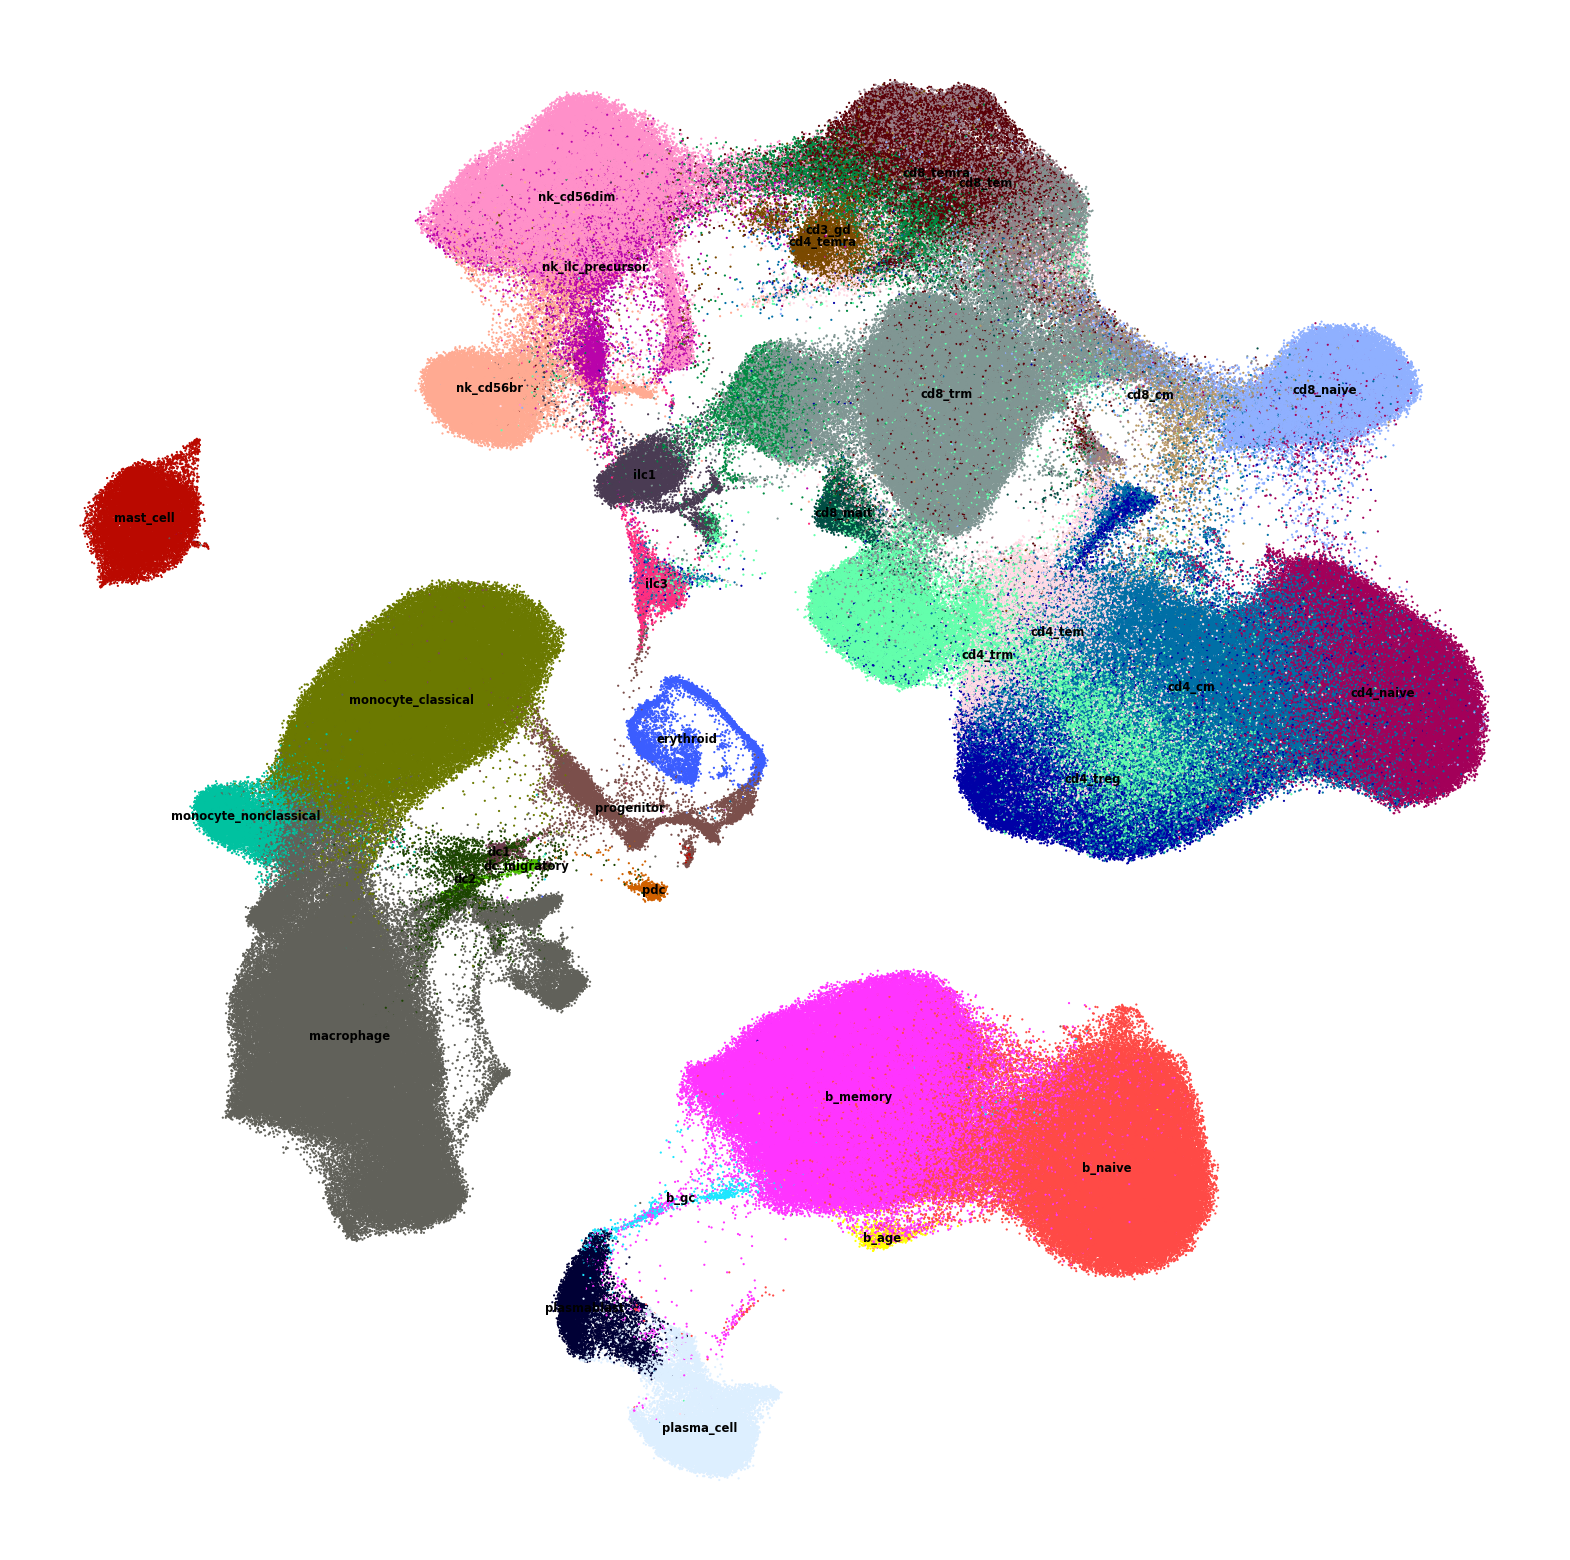

In [195]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    immune_aging, 
    color="dan_correction",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, neighbors_key="mrvi_u", size=10
)

In [196]:
sc._settings.ScanpyConfig.n_jobs = -1

In [197]:
def export_mrvi_object(file_name):
    bcell = sc.read(file_name)
    print(f'There are {bcell.n_obs - len(np.intersect1d(immune_aging.obs_names, bcell.obs_names))} cells missing in mrVI embedding')
    bcell = bcell[np.intersect1d(immune_aging.obs_names, bcell.obs_names)]
    bcell.obs[['site_tech', 'donor_tissue', 'celltypes_steven']] = immune_aging.obs.loc[
        bcell.obs_names, ['site_tech', 'donor_tissue', 'celltypes_steven']]
    bcell.obsm['X_mrvi_u'] = immune_aging[bcell.obs_names].obsm['X_mrvi_u']
    bcell.obsm['X_umap'] = immune_aging[bcell.obs_names].obsm['X_umap']
    bcell.obsm['X_tsne'] = immune_aging[bcell.obs_names].obsm['X_umap_scvi_integrated_batch_key_donor_id']
    sc.pp.neighbors(bcell, use_rep="X_mrvi_u", key_added="mrvi_u", n_neighbors=7)
    sc.tl.umap(bcell, neighbors_key="mrvi_u", min_dist=0.5)
    sc.tl.leiden(bcell, resolution=20., key_added='leiden_mrvi', neighbors_key="mrvi_u")

    votes = pd.crosstab(bcell.obs['celltypes_steven'], bcell.obs['leiden_mrvi'])
    majority = votes.idxmax(axis=0)
    freqs = (votes / votes.sum(axis=0).values).max(axis=0)
    majority[freqs < 0.7] = 'Heterogeneous'
    bcell.obs['steven_majority_voting'] = majority[bcell.obs['leiden_mrvi']].values
    
    return bcell

In [198]:
import torch
torch.cuda.empty_cache()

In [199]:
tcell = export_mrvi_object('../doublet_removal/processing_results_newest/process_integration/T/T.unstim_cleanup.v2.h5ad')
bcell = export_mrvi_object('../doublet_removal/processing_results_newest/process_integration/B/B.unstim_cleanup.v2.h5ad')
myeloid = export_mrvi_object('../doublet_removal/processing_results_newest/process_integration/M/M.unstim_cleanup.v2.h5ad')

Only considering the two last: ['.v2', '.h5ad'].
Only considering the two last: ['.v2', '.h5ad'].
There are 4987 cells missing in mrVI embedding


/tmp/ipykernel_1597959/1005629719.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [202]:
tcell.obs[['schpf_groups']] = immune_aging.obs.loc[tcell.obs_names, ['schpf_groups']]

In [203]:
tcells = tcell[tcell.obs['schpf_groups'].isin(['cd4', 'cd8'])]
ilcs = tcell[~tcell.obs['schpf_groups'].isin(['cd4', 'cd8'])]

In [204]:
sc.tl.umap(tcells, neighbors_key="mrvi_u", min_dist=0.5)

/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


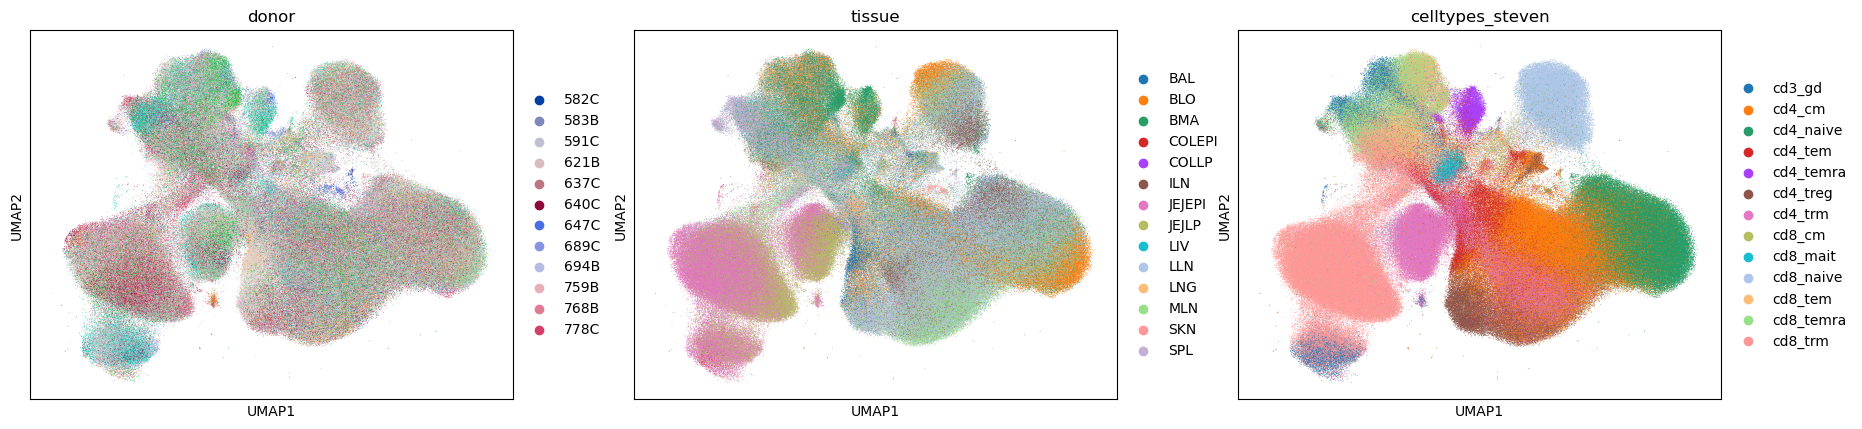

In [205]:
sc.pl.umap(
    tcells, 
    color=["donor", "tissue", "celltypes_steven"], size=1
)

/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/tools/_umap.py:166: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


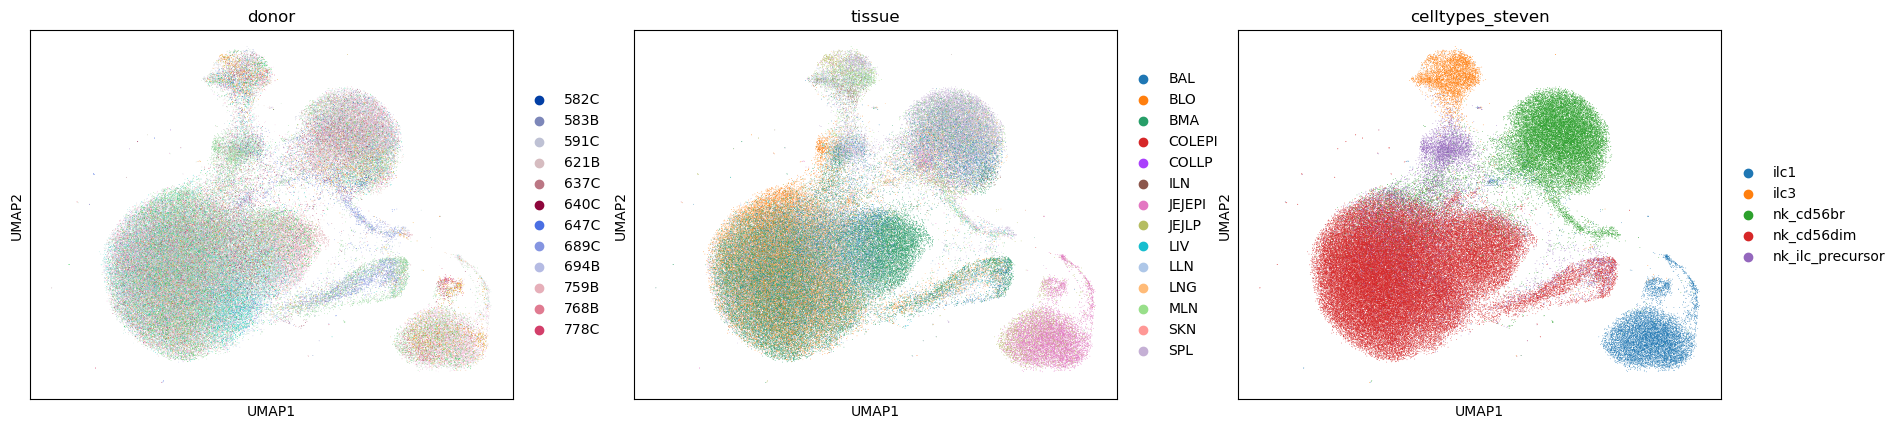

In [206]:
sc.tl.umap(ilcs, neighbors_key="mrvi_u", min_dist=0.5)
sc.pl.umap(
    ilcs, 
    color=["donor", "tissue", "celltypes_steven"], size=1
)

/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


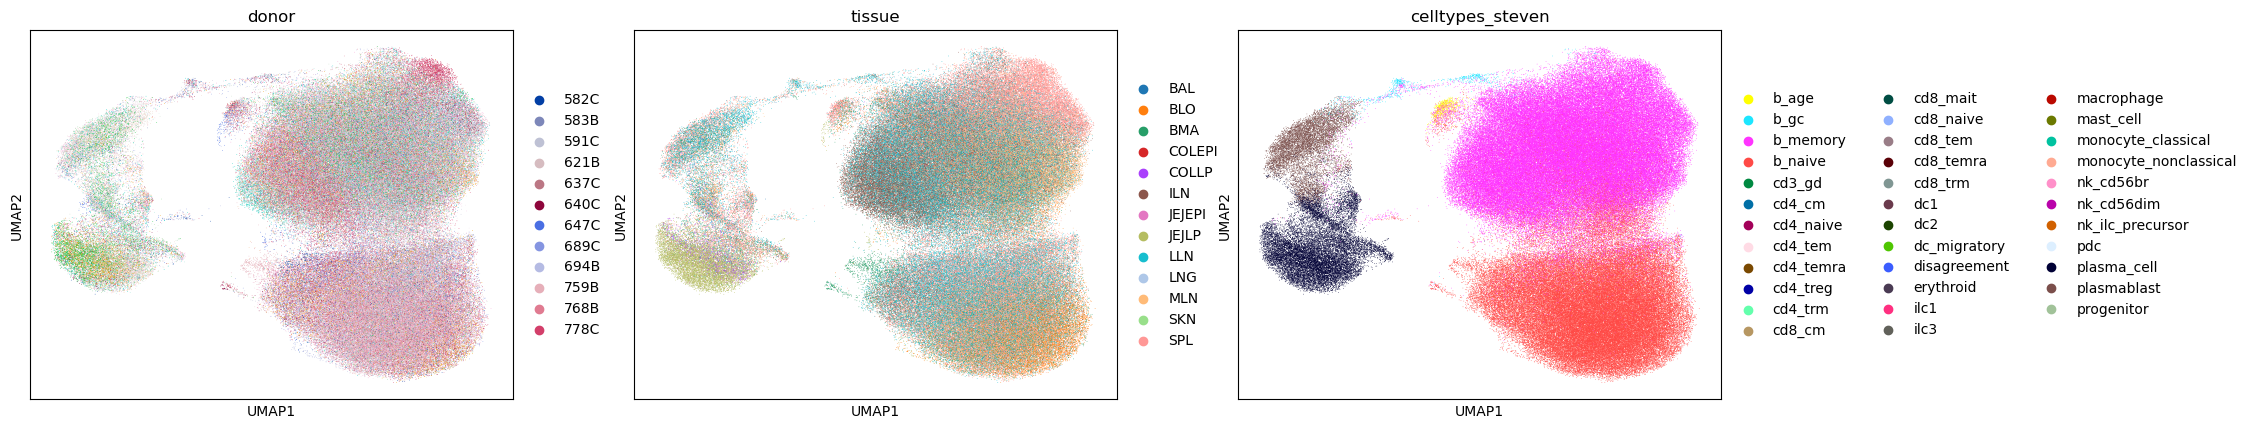

In [207]:
sc.pl.umap(
    bcell, 
    color=["donor", "tissue", "celltypes_steven"], size=1
)

/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


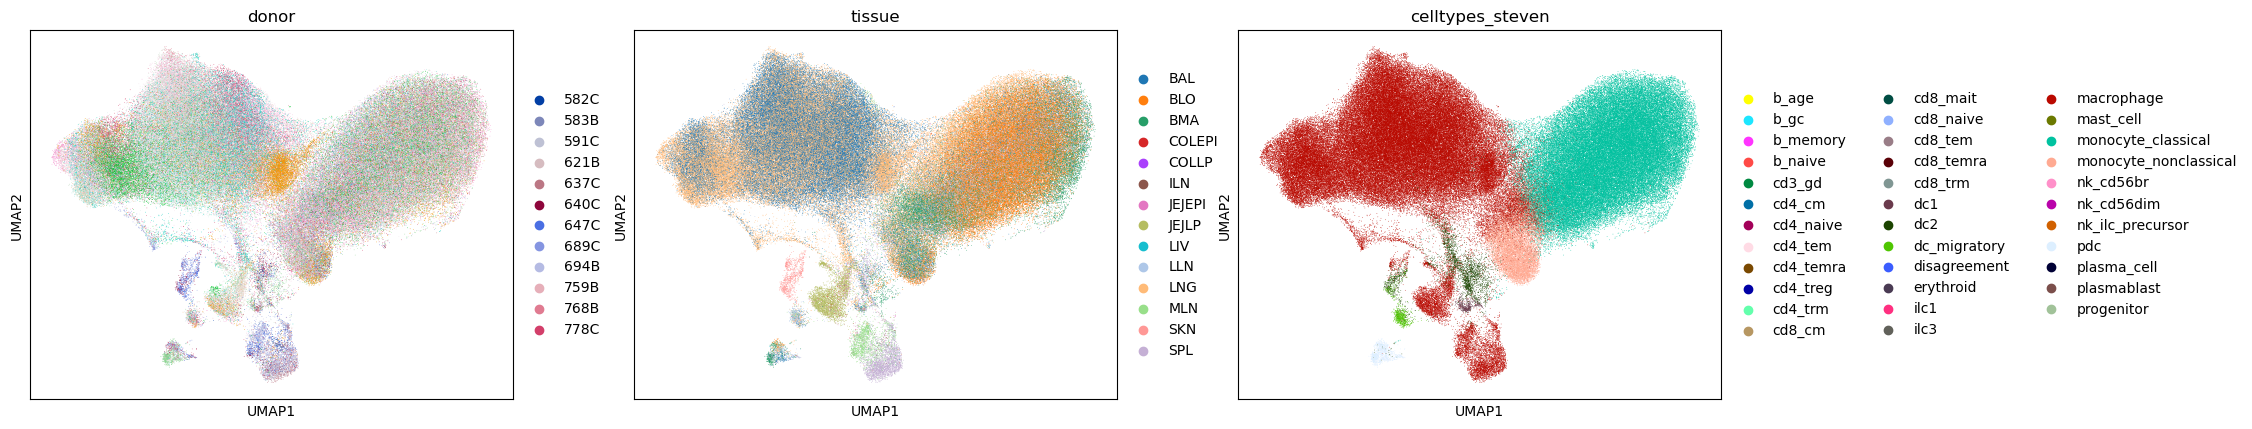

In [208]:
sc.pl.umap(
    myeloid, 
    color=["donor", "tissue", "celltypes_steven"], size=1
)

In [210]:
tcells.write("processed_mrvi_donor_cd3_tcell.h5ad")
ilcs.write("processed_mrvi_donor_ilc.h5ad")
del bcell.uns['site_colors']

KeyError: 'site_colors'

In [211]:
del myeloid.uns['site_colors']
myeloid.write("processed_mrvi_donor_myeloid.h5ad")
del tcell.uns['site_colors']
myeloid.write("processed_mrvi_donor_tcell.h5ad")
bcell.write("processed_mrvi_donor_bcell.h5ad")
immune_aging.write("processed_mrvi_donor_all.h5ad")

In [212]:
!aws s3 cp processed_mrvi_donor_ilc.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_ilc.h5ad
!aws s3 cp processed_mrvi_donor_cd3_tcell.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_cd3_tcell.h5ad
!aws s3 cp processed_mrvi_donor_tcell.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_tcell.h5ad
!aws s3 cp processed_mrvi_donor_bcell.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_bcell.h5ad
!aws s3 cp processed_mrvi_donor_myeloid.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_myeloid.h5ad
!aws s3 cp processed_mrvi_donor_all.h5ad s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_all.h5ad

upload: ./processed_mrvi_donor_ilc.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_ilc.h5ad
upload: ./processed_mrvi_donor_cd3_tcell.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_cd3_tcell.h5ad
upload: ./processed_mrvi_donor_tcell.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_tcell.h5ad
upload: ./processed_mrvi_donor_bcell.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_bcell.h5ad
upload: ./processed_mrvi_donor_myeloid.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_myeloid.h5ad
upload: ./processed_mrvi_donor_all.h5ad to s3://immuneaging/scanvi_integrated_samples/mrvi_embedding_final/mrvi_donor_all.h5ad


# linear_model

In [6]:
mrvi_model = scvi_v2.MrVI.load("immuneaging_mrvi_final_donor")

INFO     File immuneaging_mrvi_final_donor/model.pt already downloaded                                             
INFO     Jax module moved to GPU. Note: Pytorch lightning will show GPU is not being used for the Trainer.         


/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/yosef3/users/can/conda/envs/mrvi_new/lib/pytho ...
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/yosef3/users/can/conda/envs/mrvi_new/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/yosef3/users/can/conda/envs/mrvi_new/lib/pytho ...


Epoch 1/6:  17%|█████████████▋                                                                    | 1/6 [00:18<01:30, 18.12s/it, v_num=1, train_loss_step=4.17e+3, train_loss_epoch=4.17e+3]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/6:  17%|█████████████▋                                                                    | 1/6 [00:18<01:30, 18.13s/it, v_num=1, train_loss_step=4.17e+3, train_loss_epoch=4.17e+3]


In [7]:
import jax.numpy as jnp

In [8]:
mrvi_model.donor_info['age_int'] = [int(i.split('-')[0]) for i in mrvi_model.donor_info['age']]
mrvi_model.donor_info['age_group'] = ['<40' if i<40 else '>40' for i in mrvi_model.donor_info['age_int']]
mrvi_model.donor_info['age_group'] = mrvi_model.donor_info['age_group'].astype('category')
mrvi_model.donor_info['age_group_3'] = ['<30' if i<30 else '>60' if i>60 else '30-60' for i in mrvi_model.donor_info['age_int']]
mrvi_model.donor_info['age_group_3'] = mrvi_model.donor_info['age_group_3'].astype('category')

In [9]:
donor_keys = ['age_group', 'sex', 'chemistry', 'site']
n_sample = len(mrvi_model.sample_order)

In [11]:
linear_model = mrvi_model.perform_multivariate_analysis(donor_keys=donor_keys, batch_size=512, store_lfc=True, offset_design_matrix=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2505/2505 [51:04<00:00,  1.22s/it]


In [39]:
linear_model

<xarray.Dataset>
Dimensions:              (cell_name: 1282169, covariate: 5, latent_dim: 20,
                          gene: 6000)
Coordinates:
  * cell_name            (cell_name) object 'CGAATGTCAATAAGCA-1_CZINY-0536-14...
  * covariate            (covariate) object 'offset' 'age_group>40' ... 'siteUK'
  * latent_dim           (latent_dim) int64 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * gene                 (gene) object 'SAMD11' 'HES4' ... 'AC141272.1'
Data variables:
    beta                 (cell_name, covariate, latent_dim) float32 6.742e-08...
    effect_size          (cell_name, covariate) float32 2.536e-12 ... 31.99
    pvalue               (cell_name, covariate) float32 1.0 0.2004 ... 0.04342
    padj                 (cell_name, covariate) float64 1.0 1.0 ... 1.0 0.8895
    lfc                  (covariate, cell_name, gene) float32 -0.002718 ... 0...
    baseline_expression  (covariate, cell_name, gene) float32 1.425e-05 ... 0...

In [14]:
immune_aging = sc.read('immuneaging_mrvi_final_donor.h5ad')
obs_keys = ['es_' + i for i in linear_model.coords['covariate'].values]
immune_aging.obs[obs_keys] = linear_model['effect_size'].loc[{'cell_name': immune_aging.obs_names}].values

In [15]:
pval_obs_keys = ['padj_' + i for i in linear_model.coords['covariate'].values]
immune_aging.obs[pval_obs_keys] = - np.log10(1e-5 + linear_model['padj'].loc[{'cell_name': immune_aging.obs_names}].values)

In [ ]:
immune_aging.obs[pval_obs_keys]

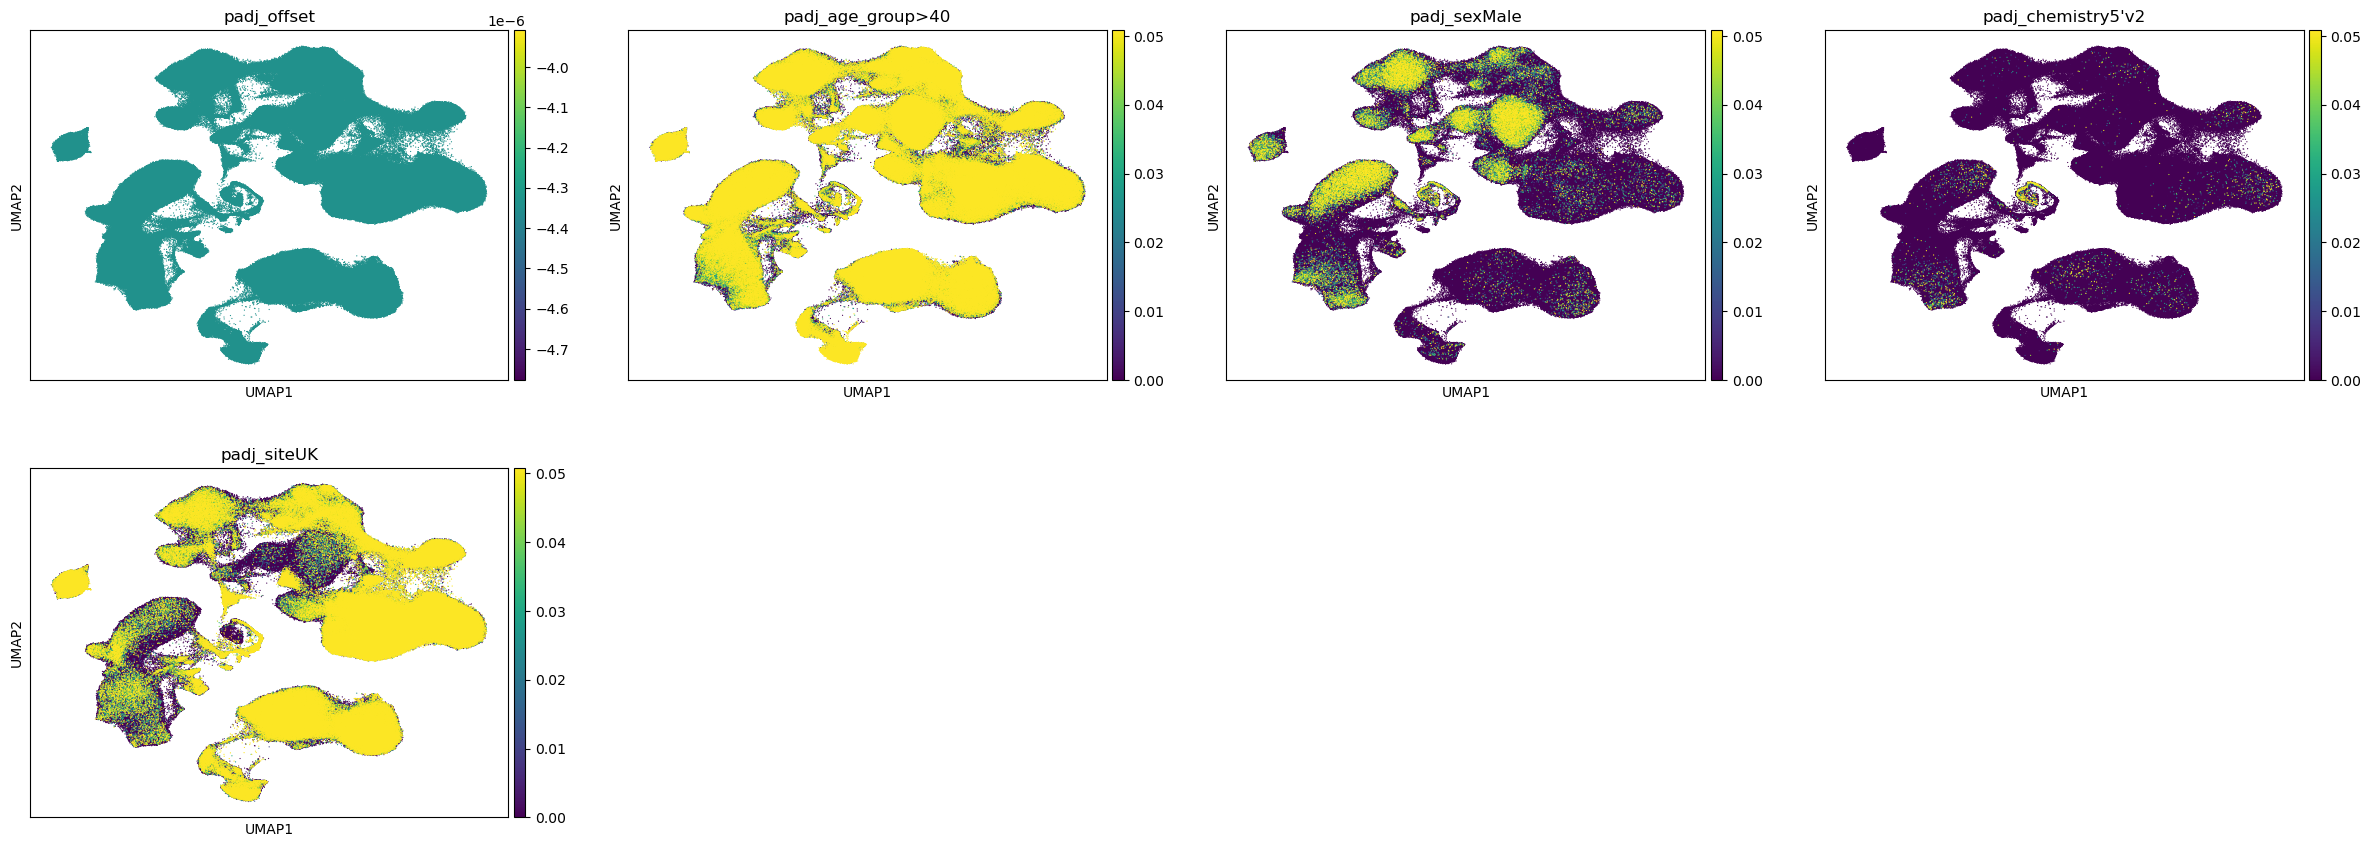

In [16]:
sc.pl.umap(immune_aging, color=pval_obs_keys, size=3)

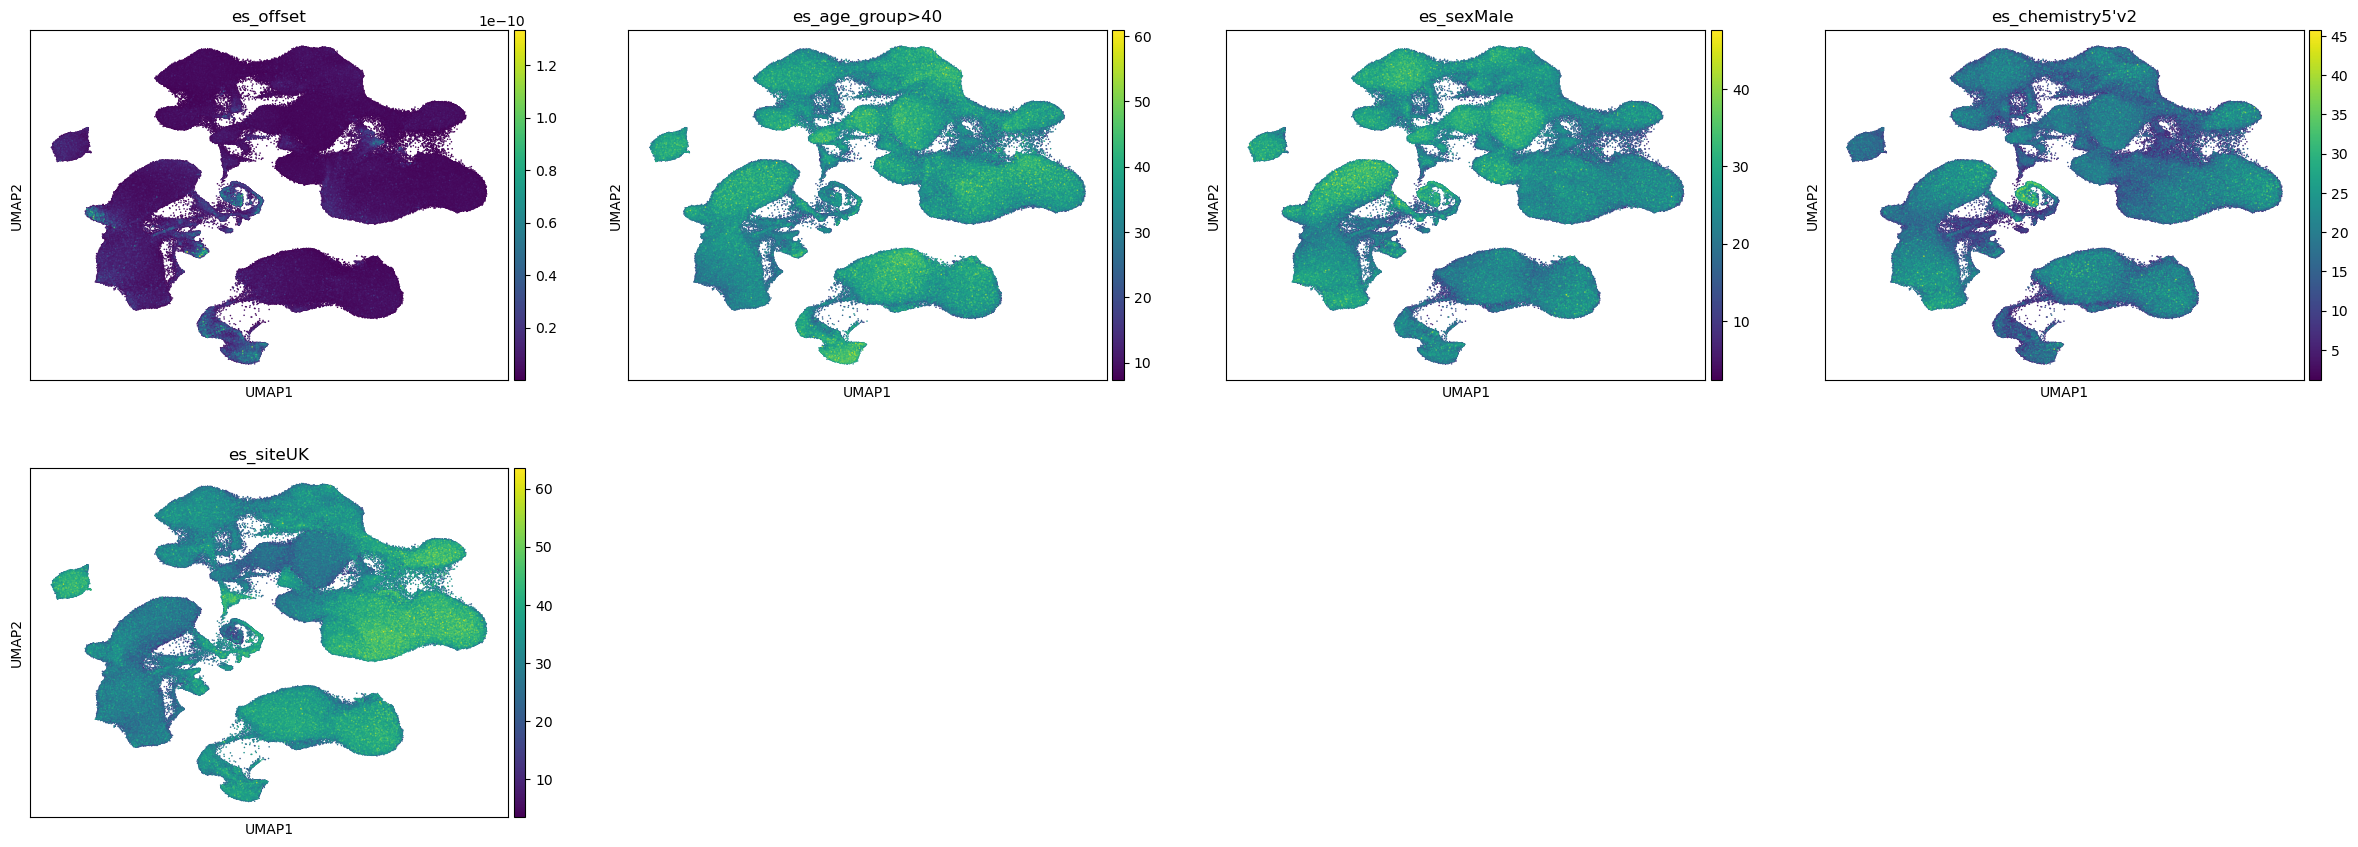

In [26]:
sc.pl.umap(immune_aging, color=obs_keys, size=5)

In [ ]:
linear_model.to_netcdf("immuneaging_mrvi_final_donor_multivariate.nc")

In [ ]:
2

<Axes: >

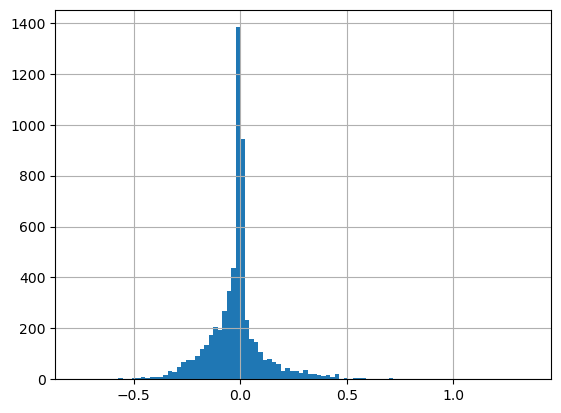

In [30]:
genes = (
    linear_model
    .loc[dict(covariate='age_group>40')]
    .loc[dict(cell_name=immune_aging.obs_names[immune_aging.obs['celltypes_steven']=='cd4_trm'])]
    .lfc
    .mean("cell_name")
    .to_pandas()
    .to_frame("LFC")
    .assign(absLFC=lambda x: np.abs(x.LFC))
    .sort_values("LFC")
)
genes.LFC.hist(bins=100)

In [31]:
for gene in genes.iloc[-200:].index:
    print(gene)
    # print(gene, genes.loc[gene].LFC)

GPRC5A
CKS2
TNFRSF8
LINC02432
U62317.4
IGSF6
CD274
SOCS3
MAFB
RND3
RASGRP3
SASH1
PLA1A
DUSP5
EBI3
RGS2
TNFSF15
AC064805.1
ENC1
IFI30
AC015912.3
COL4A2-AS2
CXCL3
CD93
CDKN1A
IL10
DEPP1
LGMN
LILRA5
PHACTR1
PILRA
EGR1
LMNA
PID1
MIR155HG
CTSL
HLA-DRB1
ALDH1A2
HILPDA
PLAUR
HLA-DQB1
KYNU
FCGR1A
CYP1B1
FAM49A
LILRB3
LINC01943
HLA-DRA
NFKBID
SMIM25
WARS
IL18BP
THBD
PTGS2
CD83
STIP1
FNIP2
GJB2
HK2
FGL2
LILRB1
IGKC
GADD45B
MSC
SERPINB2
BATF3
SLC5A3
TCEAL9
DUSP2
TNNT1
ATF3
FAM20A
HMOX1
Z82244.2
TNFSF14
CXCL2
ATP6V0D2
HAMP
ARG2
IER5L
ZC3H12A
TREM1
SGK1
ZNF703
OLIG1
NAMPT
LGALS1
PHLDA1
DEFB1
OTUD1
TM4SF1
LINC02345
C11orf96
TUBB3
ANKRD37
MIR3945HG
BCL2A1
AC091182.1
LILRA6
HSPA8
HLA-DQA1
PLA2G7
SERPINE1
NRP2
FFAR2
TIMP1
VNN1
VMO1
HSP90AB1
MRAS
RGS16
CLEC10A
NRARP
NEU1
CRYAB
SOD2
INHBA
CCR1
FCN1
ICAM1
CSF1
PARD6G-AS1
IER5
OSGIN1
CCL20
TRIB1
METTL7B
SNAI1
CXCL5
MARCKS
CD80
PLEK
IL6
PTX3
EMP1
CXCL1
CDC42EP2
TNFSF9
FLT1
TMEM158
ITGAX
DNAJB4
HCAR3
EGR3
CACYBP
LINC00877
SLAMF7
EGR2
PHLDA2
LILRB4
ADM
NR4A1


In [36]:
pd.set_option('display.max_rows', 200)

In [37]:
genes.sort_values(by='LFC').head(200)

LFC    absLFC
gene                          
AL137857.1 -0.763063  0.763063
AC009690.2 -0.754407  0.754407
FP671120.6 -0.722567  0.722567
H1FX-AS1   -0.700972  0.700972
GLDN       -0.566751  0.566751
CAMP       -0.563665  0.563665
FLRT2      -0.560967  0.560967
EGFL7      -0.558865  0.558865
CYTL1      -0.541395  0.541395
GSTM1      -0.536971  0.536971
AC004556.3 -0.528882  0.528882
APOE       -0.523048  0.523048
FP671120.7 -0.522003  0.522003
MLN        -0.507579  0.507579
HIST1H2AI  -0.501969  0.501969
AC079466.1 -0.492796  0.492796
NFIA       -0.490554  0.490554
PRKAR2B    -0.487364  0.487364
APOL4      -0.478289  0.478289
SMIM1      -0.478158  0.478158
SIGLEC12   -0.467645  0.467645
DNAAF4     -0.467620  0.467620
CEACAM4    -0.464459  0.464459
UNC5B      -0.463407  0.463407
STMN1      -0.461998  0.461998
AZU1       -0.459927  0.459927
ANOS1      -0.454488  0.454488
TLE1       -0.454304  0.454304
APOC2      -0.452812  0.452812
SLCO2B1    -0.451955  0.451955
MARVELD1   -0.450151  0.450151
GSTM2      -0.444894  0.444894
HIST1H2AJ  -0.444707  0.444707
SCGB3A1    -0.442995  0.442995
ELANE      -0.437675  0.437675
A4GALT     -0.431012  0.431012
BACE1      -0.422404  0.422404
RMI2       -0.419418  0.419418
UNG        -0.416060  0.416060
MYB        -0.415290  0.415290
FHL1       -0.413407  0.413407
PCLAF      -0.409683  0.409683
FRMD4A     -0.407090  0.407090
MT1H       -0.404979  0.404979
APOC1      -0.400970  0.400970
KEL        -0.400647  0.400647
CNRIP1     -0.397722  0.397722
TPSAB1     -0.391204  0.391204
NNMT       -0.390890  0.390890
PCSK9      -0.389557  0.389557
ACACB      -0.388577  0.388577
ADORA3     -0.387722  0.387722
TYMS       -0.384396  0.384396
WDR34      -0.382539  0.382539
ITM2C      -0.380991  0.380991
GCHFR      -0.380122  0.380122
MCM2       -0.378379  0.378379
TRHDE      -0.373472  0.373472
HIST1H1D   -0.370321  0.370321
RETREG1    -0.370135  0.370135
RGPD2      -0.369740  0.369740
PRTN3      -0.369315  0.369315
AC073349.1 -0.368493  0.368493
CDT1       -0.359430  0.359430
CENPH      -0.358661  0.358661
TREML1     -0.357575  0.357575
TCF19      -0.356199  0.356199
ICA1       -0.355556  0.355556
ADAMTS2    -0.354152  0.354152
AKR1C2     -0.353557  0.353557
CDC42BPA   -0.353553  0.353553
CARMIL1    -0.351329  0.351329
HIST1H2AM  -0.347603  0.347603
HIST1H4F   -0.347429  0.347429
SCN1B      -0.347013  0.347013
SMIM3      -0.346088  0.346088
HADH       -0.345262  0.345262
GIHCG      -0.344652  0.344652
TK1        -0.344304  0.344304
FN3K       -0.340570  0.340570
MT1M       -0.339687  0.339687
PON2       -0.339404  0.339404
CYGB       -0.338660  0.338660
SPRY1      -0.338218  0.338218
RUNX2      -0.337745  0.337745
S100A13    -0.336866  0.336866
CTSG       -0.335259  0.335259
AL031123.1 -0.333357  0.333357
GALNT12    -0.333127  0.333127
HIST1H4C   -0.331965  0.331965
HIST1H4D   -0.330114  0.330114
PROS1      -0.330082  0.330082
LINC00957  -0.328848  0.328848
STON1      -0.328845  0.328845
HIST1H1E   -0.327332  0.327332
ATP10A     -0.325914  0.325914
BRCA1      -0.325895  0.325895
STRADB     -0.324332  0.324332
GP1BA      -0.323943  0.323943
ATAD2      -0.323360  0.323360
DEFA3      -0.322991  0.322991
TMIGD3     -0.322809  0.322809
MT1G       -0.322704  0.322704
ACSM3      -0.322504  0.322504
RETN       -0.321821  0.321821
CCDC34     -0.321666  0.321666
SRPX       -0.320905  0.320905
ISYNA1     -0.320655  0.320655
MCM3       -0.320574  0.320574
TTTY14     -0.319902  0.319902
APOA1      -0.319432  0.319432
TMEM14C    -0.318523  0.318523
DEPTOR     -0.318309  0.318309
SCGB1A1    -0.317230  0.317230
LIG1       -0.317101  0.317101
CRYGD      -0.315359  0.315359
ATAD5      -0.315013  0.315013
MAGED1     -0.314584  0.314584
CFH        -0.311980  0.311980
MOGAT1     -0.311200  0.311200
HELLS      -0.310981  0.310981
FANCI      -0.309217  0.309217
GINS2      -0.307939  0.307939
VSTM2L     -0.307535  0.307535
METTL7A    -0.307135  0.307135
GPR34      -0.306479  0.306479
FAH        -0.305685  0.305685
PARAL1     -0.3055

In [38]:
genes.sort_values(by='LFC', ascending=False).head(200)

LFC    absLFC
gene                          
HSPA1A      1.354527  1.354527
HSPA6       1.313983  1.313983
HSPA1B      1.098457  1.098457
BAG3        0.950867  0.950867
CCL3        0.827478  0.827478
CCL3L1      0.789176  0.789176
CD300E      0.788499  0.788499
DNAJB1      0.769776  0.769776
DNAJA4      0.753458  0.753458
HSPH1       0.750140  0.750140
CCL2        0.741195  0.741195
TNFAIP6     0.721762  0.721762
CXCL8       0.716981  0.716981
CXCL10      0.713227  0.713227
IL1RN       0.703119  0.703119
CCL4L2      0.699807  0.699807
SERPINH1    0.682704  0.682704
HSP90AA1    0.678783  0.678783
APOBEC3A    0.675818  0.675818
G0S2        0.674352  0.674352
LUCAT1      0.644573  0.644573
GDF15       0.637685  0.637685
HSPB1       0.636517  0.636517
CCL4        0.602610  0.602610
RRAD        0.600862  0.600862
HSPD1       0.595930  0.595930
IL1A        0.589988  0.589988
IER3        0.582534  0.582534
CCL7        0.582053  0.582053
FKBP4       0.573901  0.573901
ZFAND2A     0.569228  0.569228
IL1B        0.567061  0.567061
SLC7A11     0.558181  0.558181
C15orf48    0.554106  0.554106
SPP1        0.538171  0.538171
LDLR        0.536357  0.536357
GPR84       0.533894  0.533894
TNF         0.533400  0.533400
HLA-DQA2    0.532403  0.532403
CCL8        0.525656  0.525656
HES4        0.511805  0.511805
HCAR2       0.508101  0.508101
OASL        0.507263  0.507263
FOLR3       0.500123  0.500123
LINC00346   0.499840  0.499840
TM4SF19     0.487875  0.487875
AQP9        0.486752  0.486752
CDKN1C      0.482936  0.482936
NR4A1       0.475748  0.475748
ADM         0.466401  0.466401
LILRB4      0.465040  0.465040
PHLDA2      0.464162  0.464162
EGR2        0.463704  0.463704
SLAMF7      0.463176  0.463176
LINC00877   0.462771  0.462771
CACYBP      0.461110  0.461110
EGR3        0.457611  0.457611
HCAR3       0.457366  0.457366
DNAJB4      0.457315  0.457315
ITGAX       0.456222  0.456222
TMEM158     0.455982  0.455982
FLT1        0.454177  0.454177
TNFSF9      0.453308  0.453308
CDC42EP2    0.453001  0.453001
CXCL1       0.451911  0.451911
EMP1        0.450203  0.450203
PTX3        0.449184  0.449184
IL6         0.447504  0.447504
PLEK        0.447426  0.447426
CD80        0.444173  0.444173
MARCKS      0.439829  0.439829
CXCL5       0.439239  0.439239
SNAI1       0.438825  0.438825
METTL7B     0.434801  0.434801
TRIB1       0.434185  0.434185
CCL20       0.433016  0.433016
OSGIN1      0.429023  0.429023
IER5        0.427632  0.427632
PARD6G-AS1  0.421708  0.421708
CSF1        0.421460  0.421460
ICAM1       0.417771  0.417771
FCN1        0.417262  0.417262
CCR1        0.413832  0.413832
INHBA       0.412587  0.412587
SOD2        0.411212  0.411212
CRYAB       0.410459  0.410459
NEU1        0.407158  0.407158
NRARP       0.404807  0.404807
CLEC10A     0.404391  0.404391
RGS16       0.404053  0.404053
MRAS        0.403895  0.403895
HSP90AB1    0.403128  0.403128
VMO1        0.402912  0.402912
VNN1        0.401157  0.401157
TIMP1       0.398268  0.398268
FFAR2       0.397739  0.397739
NRP2        0.397572  0.397572
SERPINE1    0.396636  0.396636
PLA2G7      0.394214  0.394214
HLA-DQA1    0.391693  0.391693
HSPA8       0.390945  0.390945
LILRA6      0.389724  0.389724
AC091182.1  0.387134  0.387134
BCL2A1      0.383077  0.383077
MIR3945HG   0.382429  0.382429
ANKRD37     0.382174  0.382174
TUBB3       0.380093  0.380093
C11orf96    0.377984  0.377984
LINC02345   0.377214  0.377214
TM4SF1      0.375839  0.375839
OTUD1       0.373913  0.373913
DEFB1       0.373461  0.373461
PHLDA1      0.373104  0.373104
LGALS1      0.372765  0.372765
NAMPT       0.371950  0.371950
OLIG1       0.371810  0.371810
ZNF703      0.370528  0.370528
SGK1        0.366032  0.366032
TREM1       0.363411  0.363411
ZC3H12A     0.363104  0.363104
IER5L       0.362017  0.362017
ARG2        0.361533  0.361533
HAMP        0.361401  0.361401
ATP6V0D2    0.359174  0.359174
CXCL2       0.358796  0.358796
TNFSF14     0.356958  0.356958
Z82244.2    0.352903  0.352903
HMOX1       0.3510